# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.viz
pboc = mut.viz.color_selector('pboc')
constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

Text(0, 0.5, 'fold-change')

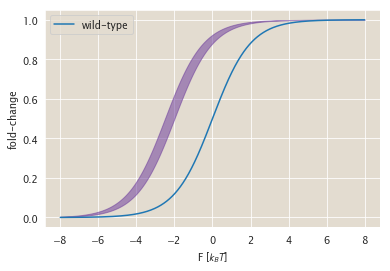

In [83]:
# fold_change = np.logspace(-4, 0, 101)[:-1]
bohr_param_wt = np.linspace(-8, 8, 1000)
bohr_param_mut_min = bohr_param_wt + 2
bohr_param_mut_max = bohr_param_wt + 2.5
fc_wt = (1 + np.exp(-bohr_param_wt))**-1
fc_mut_min = (1 + np.exp(-bohr_param_mut_min))**-1
fc_mut_max = (1 + np.exp(-bohr_param_mut_max))**-1

plt.plot(bohr_param_wt, fc_wt, label='wild-type') 
plt.fill_between(bohr_param_wt, fc_mut_min, fc_mut_max, color='rebeccapurple', alpha=0.5)
plt.legend()
plt.xlabel('F [$k_BT$]')
plt.ylabel('fold-change')


(0, -2)

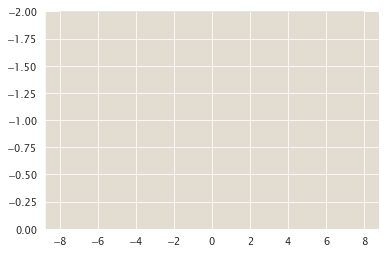

In [84]:
plt.plot(bohr_param_wt, bohr_param_wt - bohr_param_mut_min)
plt.plot(bohr_param_wt, bohr_param_wt - bohr_param_mut_max)
plt.ylim([0, -2])

The derivative of $F_\text{empirical}$ with respect to the fold-change is

$$
{d F_\text{empirical} \over d \text{fold-change}} = {1 \over \text{fold-change}(\text{fold-change} -1 )}
$$

In [88]:
df = 1 / (fc_mut_min * (fc_mut_max - 1))

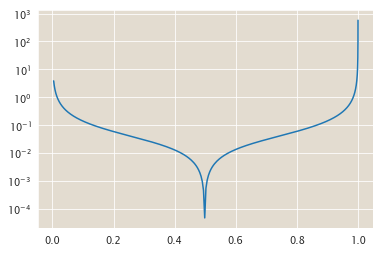

In [89]:
plt.semilogy(fc_mut_max[:-1], np.abs(np.diff(-(fc_mut_max * (fc_mut_max - 1))**-1)) )

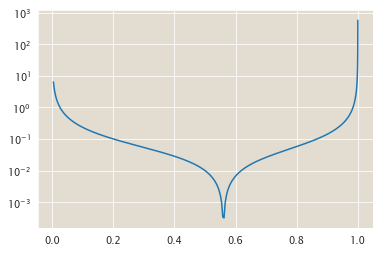

In [96]:
plt.semilogy(fc_mut_max[:-1], np.abs(np.diff(df)))

In [146]:
fc_true = np.logspace(-4, 0, 100)
fc = fc_true -0.015
F_true = -np.log((1 /fc_true) -1)
F_noise = -np.log((1 / fc) - 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


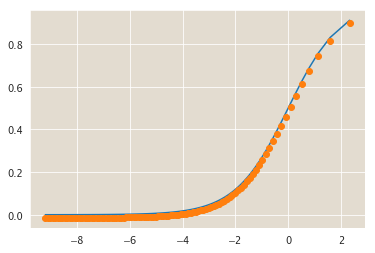

In [147]:
plt.plot(F_true, fc_true)
plt.plot(F_true, fc, 'o')

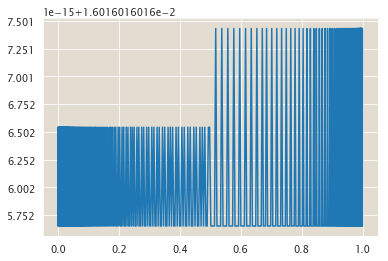

In [150]:
col = (1 + np.exp(-bohr_param))**-1
plt.plot(col[:-1], np.diff(bohr_param))

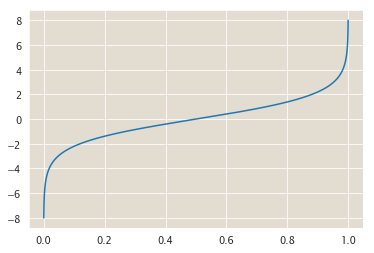

In [151]:
plt.plot(col, bohr_param)

In [152]:
col

array([3.35350130e-04, 3.40762500e-04, 3.46262192e-04, 3.51850614e-04,
       3.57529197e-04, 3.63299395e-04, 3.69162683e-04, 3.75120564e-04,
       3.81174562e-04, 3.87326227e-04, 3.93577132e-04, 3.99928878e-04,
       4.06383089e-04, 4.12941419e-04, 4.19605544e-04, 4.26377170e-04,
       4.33258030e-04, 4.40249884e-04, 4.47354521e-04, 4.54573758e-04,
       4.61909443e-04, 4.69363453e-04, 4.76937693e-04, 4.84634101e-04,
       4.92454646e-04, 5.00401328e-04, 5.08476179e-04, 5.16681265e-04,
       5.25018684e-04, 5.33490567e-04, 5.42099082e-04, 5.50846429e-04,
       5.59734844e-04, 5.68766601e-04, 5.77944008e-04, 5.87269411e-04,
       5.96745194e-04, 6.06373779e-04, 6.16157627e-04, 6.26099239e-04,
       6.36201155e-04, 6.46465957e-04, 6.56896268e-04, 6.67494753e-04,
       6.78264119e-04, 6.89207119e-04, 7.00326548e-04, 7.11625245e-04,
       7.23106099e-04, 7.34772039e-04, 7.46626047e-04, 7.58671150e-04,
       7.70910422e-04, 7.83346990e-04, 7.95984029e-04, 8.08824765e-04,
      